# **Imports**

In [1]:
import pandas as pd
#import ydata_profiling as pp
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# **Problem**
Predict the average price of apples for the following week

In [2]:
file = 'apples.csv'
df = pd.read_csv(file)
df.dtypes

Unnamed: 0         int64
date              object
average_price    float64
total_volume       int64
gala               int64
fuji               int64
granny_smith       int64
total_bags         int64
s_bags             int64
l_bags             int64
xl_bags            int64
type              object
region            object
dtype: object

# **1. Pre-process**

Working only with region TotalUS due to granularity 

In [3]:
##Pre-pre-process

#Removing what is not TotalUS
df = df[df['region'] == 'TotalUS'].copy()

#Casting date as datetime type
df['date'] = pd.to_datetime(df['date'], format='%m/%d/%Y')
df = df.sort_values('date')

#Separating by conventional and organic
df_conv = df[df['type'] == 'conventional']
df_org = df[df['type'] == 'organic']

#Choosing columns of interest
columns_of_interest = ['date', 'average_price', 'total_volume', 'gala', 'fuji', 'granny_smith', 'total_bags', 's_bags', 'l_bags', 'xl_bags']
df_conv = df_conv[columns_of_interest]
df_org = df_org[columns_of_interest]
columns_of_interest.append('type')
df = df[columns_of_interest]

In [4]:
#Calender features
def calender_features(data):
    data['week'] = data['date'].dt.isocalendar().week
    data['week'] = data['week'].astype('int32')
    data['month'] = data['date'].dt.month
    data['year'] = data['date'].dt.year

calender_features(df)
calender_features(df_conv)
calender_features(df_org)


# **2.Exploratory data-analysis**

In [5]:
#Seaborn styles
sns.set_theme()
sns.set(style="whitegrid")
sns.set_palette("Set2")
plt.style.use('seaborn-v0_8')

Data distribution by year

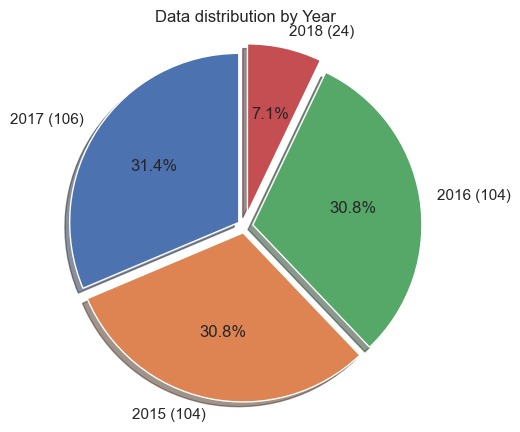

In [6]:
year_count = df["year"].value_counts()
sns.set(font_scale=1)

plt.figure(figsize=(5, 5))
plt.title("Data distribution by Year")

explode = (0.04, 0.04, 0.05, 0.08)  

labels = [f"{year} ({count})" for year, count in zip(year_count.index, year_count.values)]

plt.pie(year_count, labels=labels, autopct='%1.1f%%', explode=explode, shadow=True, startangle=90)
plt.axis('equal')  # Equal aspect ratio ensures that the pie is drawn as a circle

plt.show()

2018 has less data, we don't have the hole year
2016 and 2015 have 52 weeks each (double the data because we're dealing with two types)
2017 has 53 weeks?

Total volume by type

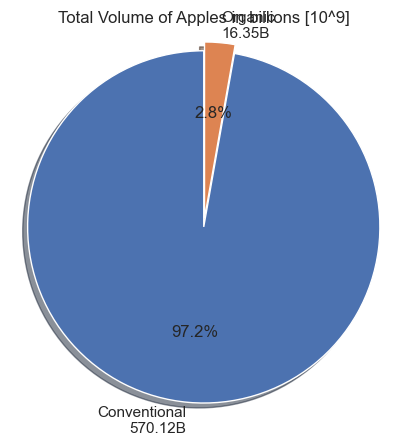

In [7]:
conv_totalV = df_conv['total_volume'].sum() / 1e9
orga_totalV = df_org['total_volume'].sum() / 1e9
values = [round(conv_totalV, 2), round(orga_totalV, 2)]
labels = ['Conventional', 'Organic']

sns.set(font_scale=1)
plt.figure(figsize=(5, 5))
plt.title('Total Volume of Apples in billions [10^9]')

# Explode a slice for emphasis (optional)
explode = (0, 0.05)

# Label formatting
labels_with_values = [f'{label}\n{value:.2f}B' for label, value in zip(labels, values)]

plt.pie(values, labels=labels_with_values, autopct='%1.1f%%', explode=explode, shadow=True, startangle=90)
plt.axis('equal')  # Equal aspect ratio ensures that the pie is drawn as a circle

plt.show()


Conventional apples by cultivar

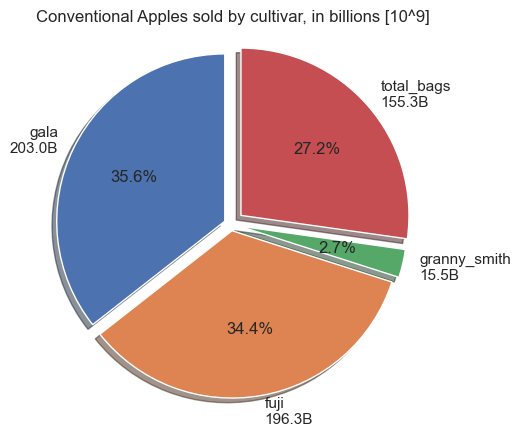

In [8]:
def pie_chart_per_apple_type(d, title):
    apple_type = ['gala', 'fuji', 'granny_smith', 'total_bags']
    values = [round(d[apple].sum() / 1e9, 1) for apple in apple_type]
    labels = [f'{label}\n{value:.1f}B' for label, value in zip(apple_type, values)]

    sns.set(font_scale=1)
    plt.figure(figsize=(5, 5))
    plt.title(title)

    explode = (0.04, 0.04, 0.05, 0.08)  

    plt.pie(values, labels=labels, autopct='%1.1f%%', explode=explode, shadow=True, startangle=90)
    plt.axis('equal')  # Equal aspect ratio ensures that the pie is drawn as a circle

    plt.show()

pie_chart_per_apple_type(df_conv, 'Conventional Apples sold by cultivar, in billions [10^9]')


Price and volume analysis

1.65
0.76
2.09
1.0


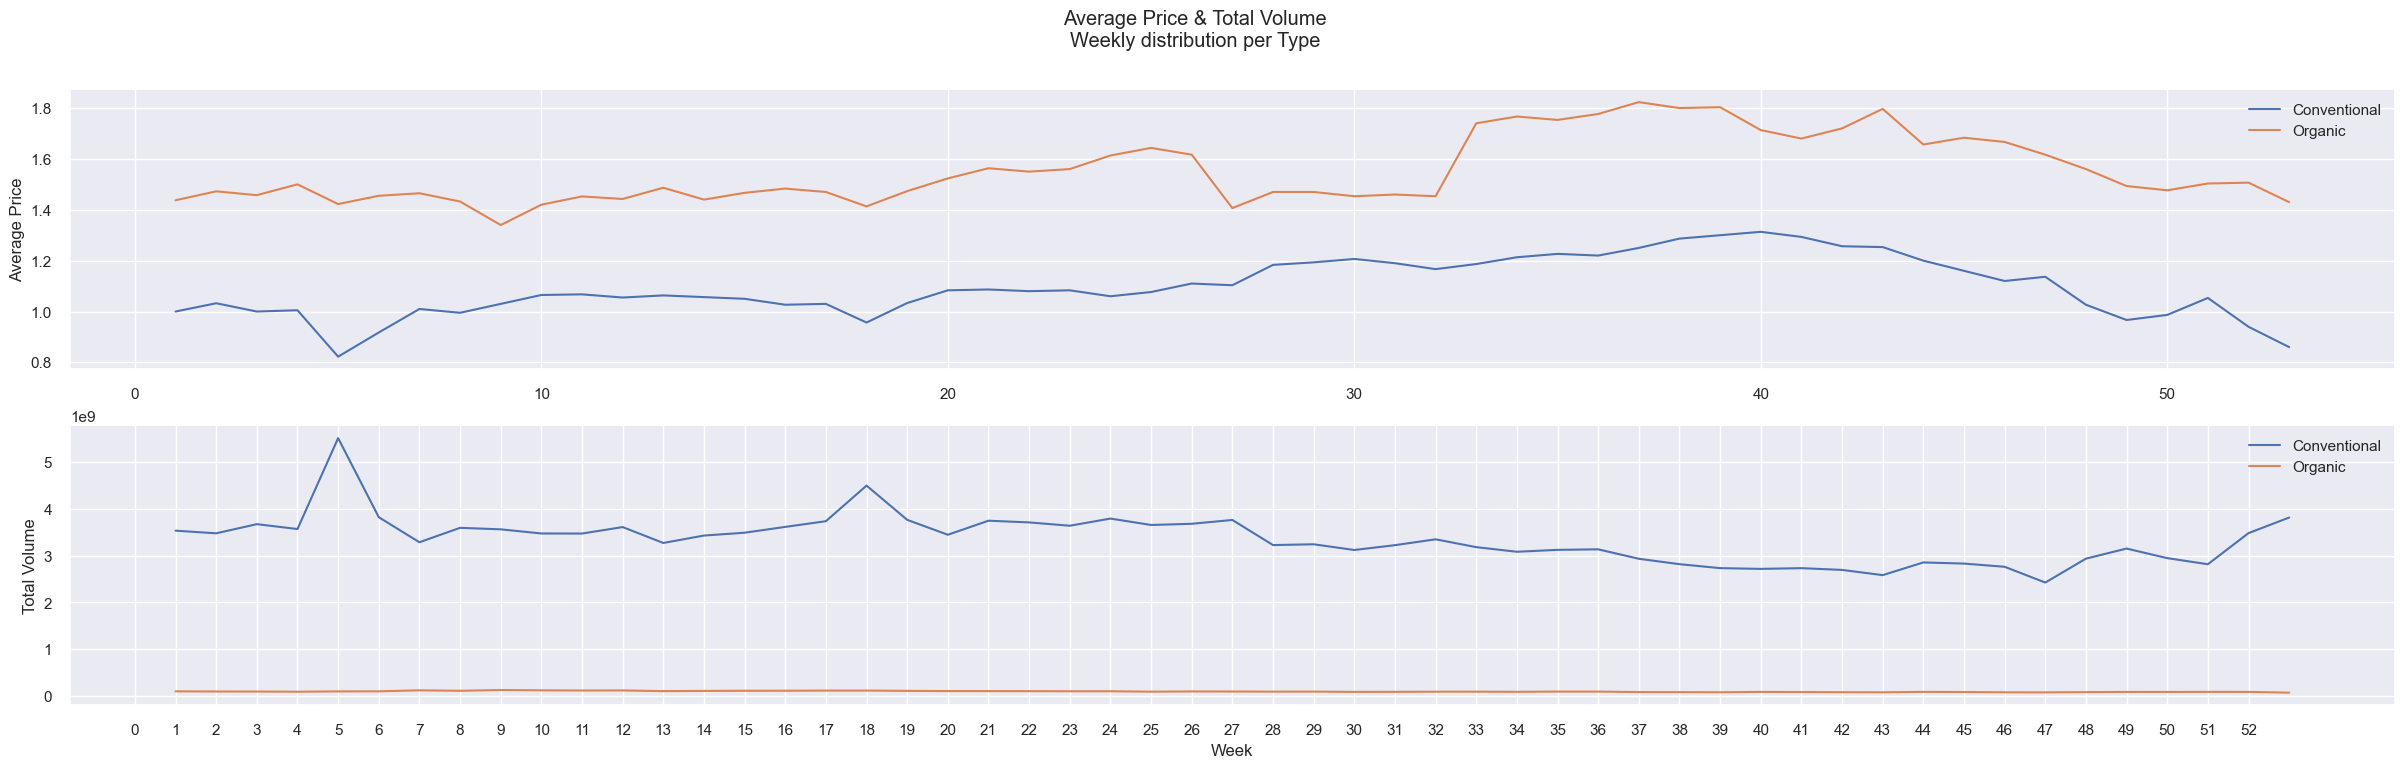

In [9]:
figure, ax = plt.subplots(2,1,figsize=(30,8))
listOf_Xticks = np.arange(0, 53, 1)
plt.xticks(listOf_Xticks)
figure.suptitle("Average Price & Total Volume\nWeekly distribution per Type")
plt.xlabel("Week")
ax[0].set_ylabel("Average Price")
ax[1].set_ylabel("Total Volume")

#Feature engineeering
df_org['week'] = df_org['date'].dt.isocalendar().week

#df_avg_price_conv = df[df['type']=='conventional']
#df_avg_price_org = df[df['type']=='organic']
df_avg_price_conv_week = df_conv['average_price'].groupby(df_conv['week']).mean()
df_avg_price_org_week =  df_org['average_price'].groupby(df_org['week']).mean()
df_volume_conv_week = df_conv['total_volume'].groupby(df_conv['week']).mean()
df_volume_org_week =  df_org['total_volume'].groupby(df_org['week']).mean()


ax[0].plot(df_avg_price_conv_week, label="Conventional")
ax[0].plot(df_avg_price_org_week, label="Organic")
ax[1].plot(df_volume_conv_week, label="Conventional")
ax[1].plot(df_volume_org_week, label="Organic")
ax[0].legend()
ax[1].legend()

print(df_conv['average_price'].max())
print(df_conv['average_price'].min())
print(df_org['average_price'].max())
print(df_org['average_price'].min())

Monthly average prices

In [10]:
def groupby_month(d): #Group by month and average the price
    d_new = d.groupby('month')['average_price'].mean().reset_index()
    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    d_new['month'] = d_new['month'].apply(lambda x: months[x - 1])
    return d_new #Returns list of average prices for each month

def grafico_fixe(d): #escolham um melhor nome pls
    years = d['year'].unique()
    for year in years:
        provisoria = groupby_month(d[d['year']==year])
        sns.scatterplot(x=provisoria['month'], y=provisoria['average_price'], label=year)
        plt.plot(provisoria['month'], provisoria['average_price'])

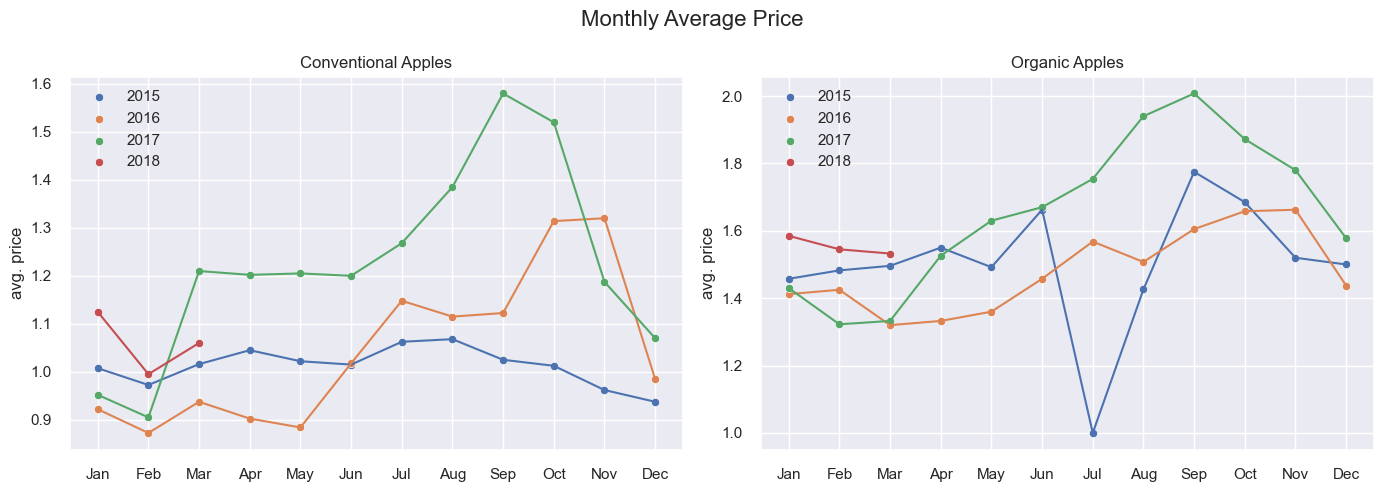

In [11]:
plt.figure(figsize=(14, 5))
plt.suptitle('Monthly Average Price', fontsize=16)

plt.subplot(1, 2, 1) #1st plot
grafico_fixe(df_conv)
plt.xlabel('')
plt.ylabel('avg. price')
plt.title('Conventional Apples')
plt.legend(loc='upper left')

plt.subplot(1, 2, 2) #2nd plot
grafico_fixe(df_org)
plt.xlabel('')
plt.ylabel('avg. price')
plt.title('Organic Apples')
plt.legend()
plt.tight_layout()

Acrescentei

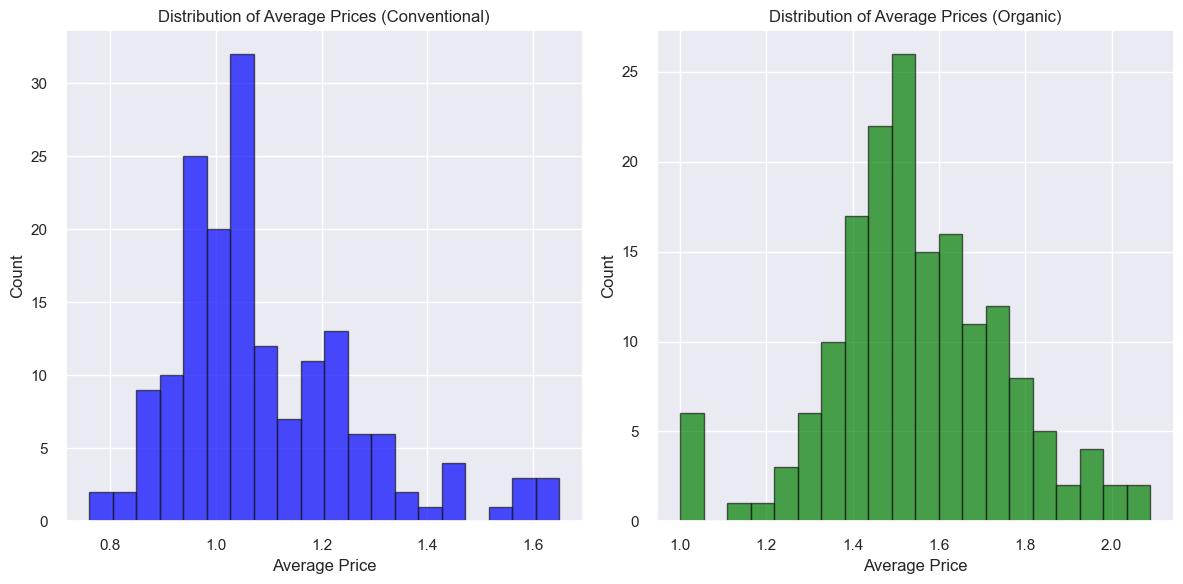

In [36]:
import matplotlib.pyplot as plt

# Filtrar dados para o tipo "conventional"
conventional_data = df[df["type"] == "conventional"]
organic_data = df[df["type"] == "organic"]

plt.figure(figsize=(12, 6))

# Histograma para o tipo "conventional"
plt.subplot(1, 2, 1)
plt.hist(conventional_data["average_price"], bins=20, edgecolor='k', alpha=0.7, color='blue')
plt.title("Distribution of Average Prices (Conventional)")
plt.xlabel("Average Price")
plt.ylabel("Count")
plt.grid(True)

# Histograma para o tipo "organic"
plt.subplot(1, 2, 2)
plt.hist(organic_data["average_price"], bins=20, edgecolor='k', alpha=0.7, color='green')
plt.title("Distribution of Average Prices (Organic)")
plt.xlabel("Average Price")
plt.ylabel("Count")
plt.grid(True)

plt.tight_layout()  # Para ajustar a exibição

plt.show()


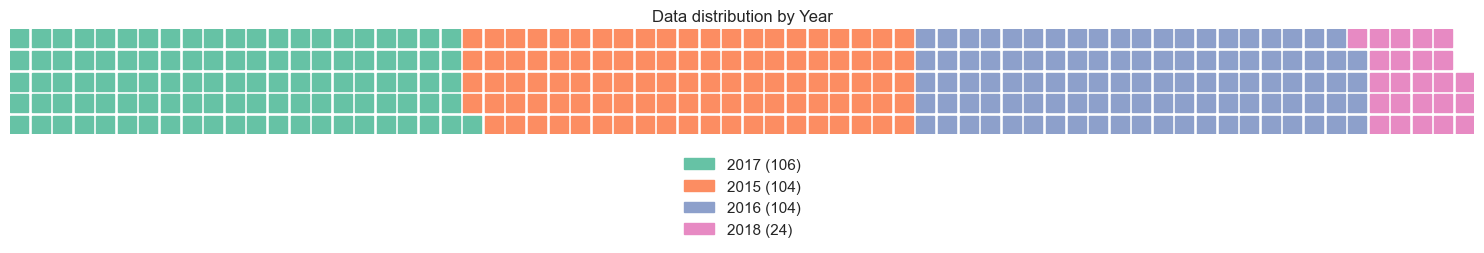

In [37]:
from pywaffle import Waffle
import matplotlib.pyplot as plt

year_count = df["year"].value_counts()
labels = [f"{year} ({count})" for year, count in zip(year_count.index, year_count.values)]

fig = plt.figure(
    FigureClass=Waffle,
    rows=5,
    values=year_count.values,
    labels=labels,
    figsize=(15, 10),
    legend={'loc': 'upper center', 'bbox_to_anchor': (0.5, -0.1)}
)

plt.title("Data distribution by Year")
plt.show()


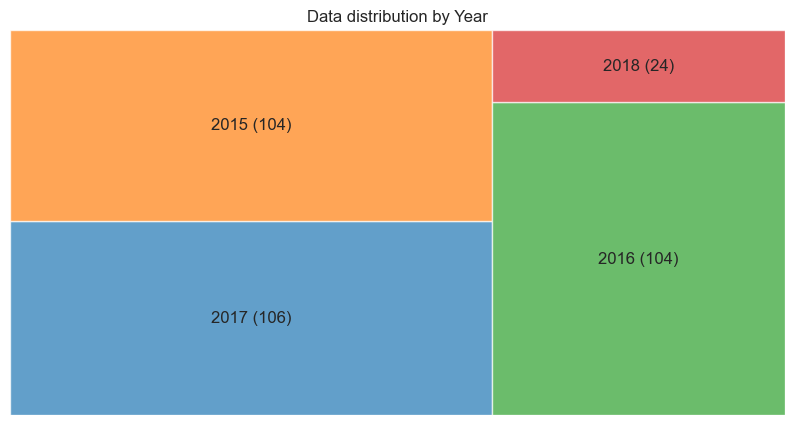

In [39]:
import squarify
import matplotlib.pyplot as plt

year_count = df["year"].value_counts()
labels = [f"{year} ({count})" for year, count in zip(year_count.index, year_count.values)]

# Especifique as cores que você deseja para cada caixa
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b"]

plt.figure(figsize=(10, 5))
plt.title("Data distribution by Year")

# Passe as cores personalizadas para a função squarify.plot
squarify.plot(sizes=year_count.values, label=labels, alpha=0.7, color=colors)

plt.axis('off')  # Remove os eixos
plt.show()



That dip on organic prices (jul-2015) needs to be solved! 

# **3. Models**

In [12]:
df_conv['target'] = df_conv['average_price'].shift(-1)
df_conv = df_conv.loc[df_conv['target'].notna()].copy().reset_index(drop = True)

split_date = pd.to_datetime('2018-01-01')

#Spliting into training and test data
df_conv_train = df_conv.loc[df_conv['date'] < split_date].copy().reset_index(drop=True)
df_conv_test = df_conv.loc[df_conv['date'] >= split_date].copy().reset_index(drop=True)

def print_stats(df_set, df):
    print(f'Percentage of original: {len(df_set) / len(df):.0%}')
    print('Target min: {}'.format(df_set["target"].min()))
    print(f'Target median:\t{df_set["target"].median():,.2f}')
    print(f'Target mean:\t{df_set["target"].mean():,.2f}')
    print(f'Target max:\t{df_set["target"].max():,.2f}')

print('\nFull train')
print_stats(df_conv_train, df_conv)
print('\nTest')
print_stats(df_conv_test, df_conv)


Full train
Percentage of original: 93%
Target min: 0.76
Target median:	1.04
Target mean:	1.10
Target max:	1.65

Test
Percentage of original: 7%
Target min: 0.87
Target median:	1.07
Target mean:	1.05
Target max:	1.20


3.1 Baseline: xgboost gradient descent regression

In [13]:
from xgboost import XGBRegressor

#Hyper-parameters
algo_params = {
    'max_depth': 6, #tree-depth
    'n_estimators': 80, #number of trees
}
algo_params['seed'] = 123 
algo_params['n_jobs'] = -1 #PC config to use all local clusters
algo_params['tree_method'] = 'hist' #histogram-based method for faster training
algo_params['use_label_encoder'] = False #No label encoding for categorical features

#Create instance of regression model with the params
model = XGBRegressor(**algo_params)  #**: dic key-value pairs as keyword args to the constructor 
                                     #-> same thing as explicitly writing each h-param in the function

#### features used
numeric_features_used = [
    'average_price',
    'total_volume',
    'gala',
    'fuji',
    'granny_smith',
    'total_bags',
    's_bags',
    'l_bags',
    'xl_bags',
]

model.fit( #Training the model
    df_conv_train[numeric_features_used],
    df_conv_train['target']
    )

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=80, n_jobs=-1,
             num_parallel_tree=None, random_state=None, ...)

Evaluating the model

In [14]:
from sklearn.metrics import mean_squared_error

def print_score(model, train, test, features):
    preds_train = model.predict(train[features])
    rmse_train = mean_squared_error(train['target'], preds_train, squared = False)

    preds_test = model.predict(test[features])
    rmse_test = mean_squared_error(test['target'], preds_test, squared = False)

    overfit = rmse_test - rmse_train

    print(f'Train score: {rmse_train:,.5f}')
    print(f'Test score: {rmse_test:,.5f} \t||\t Overfit: {overfit:,.5f}\n')
    
print_score(model, df_conv_train, df_conv_test, numeric_features_used)

Train score: 0.00091
Test score: 0.11312 	||	 Overfit: 0.11221



In [15]:
if hasattr(model, 'feature_importances_'):
    feature_importances = model.feature_importances_
    
#Create a DataFrame for feature importances
feature_importance_df = pd.DataFrame({'Feature': numeric_features_used, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the table
feature_importance_df

,Feature,Importance
0,average_price,0.794081
5,total_bags,0.043269
8,xl_bags,0.033429
2,gala,0.026290
3,fuji,0.026186
6,s_bags,0.024848
7,l_bags,0.022317
1,total_volume,0.019450
4,granny_smith,0.010132


3.2 Feature Engineering

In [16]:
#Moving average for average_price
month_size = 4
df_conv['RM_avgP_M'] = df_conv['average_price'].rolling(window=month_size, min_periods=0).mean()

#Price elasticity: measure of how price increase affects volume
df_conv['price_elasticity'] = (df_conv['total_volume'].pct_change())/(df_conv['average_price'].pct_change())
df_conv.at[0, 'price_elasticity'] = 0 #Coloca '0' como o primeiro valor da price elasticity, qual seria uma boa opção?

numeric_features_used = [
    'average_price',
    'total_volume',
    'gala',
    'fuji',
    'granny_smith',
    'total_bags',
    's_bags',
    'l_bags',
    'xl_bags',
    'RM_avgP_M',
    'week',
    'month',
    'year',
    #'price_elasticity'
]

#Spliting into training and test data
df_conv_train = df_conv.loc[df_conv['date'] < split_date].copy().reset_index(drop=True)
df_conv_test = df_conv.loc[df_conv['date'] >= split_date].copy().reset_index(drop=True)


xgboost gradient descent regression with grid search

In [17]:
#Finding the best h-params for Xgboost model by grid search and cross-validation (TimeSeriesSplit)
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.compose import TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import MinMaxScaler

# basic config to be used in all combinations
algo_params['seed'] = 123
algo_params['n_jobs'] = -1
algo_params['tree_method'] = 'hist'
algo_params['use_label_encoder'] = False

#core model
model = XGBRegressor(**algo_params)

#target transformer
target_scale = MinMaxScaler(feature_range = (1, 10000))
target_norm = QuantileTransformer(
    n_quantiles = 100,
    output_distribution = 'normal',
    random_state = 123
)
target_norm = Pipeline([('min', target_scale), ('quantile', target_norm)])

#model inside a pipeline
model = TransformedTargetRegressor(regressor = model, transformer = target_norm)

# params to search for
parameters = {
    'regressor__n_estimators': [60, 80], 
    'regressor__max_depth': [5, 7],
}

# if you were using a model without transformers and pipeline, would be something like this
# parameters = {
#     'n_estimators': [60, 80], 
#     'max_depth': [5, 7],
# }

cv_splitter = TimeSeriesSplit(
    n_splits = 3,
    gap = 0,
)

#Trains the model on different combinations of h-params
#Evaluates performance with cv amd chooses the best combination
grid = GridSearchCV(
    estimator = model,
    param_grid = parameters,
    cv = cv_splitter,
    n_jobs = -1,
    refit = True,
)

grid.fit(
    df_conv_train[numeric_features_used],
    df_conv_train['target'],
)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=TransformedTargetRegressor(regressor=XGBRegressor(base_score=None,
                                                                         booster=None,
                                                                         callbacks=None,
                                                                         colsample_bylevel=None,
                                                                         colsample_bynode=None,
                                                                         colsample_bytree=None,
                                                                         device=None,
                                                                         early_stopping_rounds=None,
                                                                         enable_categorical=False,
                                                                         eval_metric=None,
                                                                         feature_types...
                                                                         multi_strategy=None,
                                                                         n_estimators=80,
                                                                         n_jobs=-1,
                                                                         num_parallel_tree=None,
                                                                         random_state=None, ...),
                                                  transformer=Pipeline(steps=[('min',
                                                                               MinMaxScaler(feature_range=(1,
                                                                                                           10000))),
                                                                              ('quantile',
                                                                               QuantileTransformer(n_quantiles=100,
                                                                                                   output_distribution='normal',
                                                                                                   random_state=123))])),
             n_jobs=-1,
             param_grid={'regressor__max_depth': [5, 7],
                         'regressor__n_estimators': [60, 80]})

In [18]:
pd.DataFrame(grid.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__max_depth,param_regressor__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.068964,0.014395,0.007156,0.006485,5,60,"{'regressor__max_depth': 5, 'regressor__n_esti...",-0.268065,-1.150348,0.099797,-0.439539,0.524575,3
1,0.090963,0.014132,0.004537,0.001056,5,80,"{'regressor__max_depth': 5, 'regressor__n_esti...",-0.268063,-1.150733,0.097914,-0.440294,0.524104,4
2,0.072971,0.024321,0.004995,0.002170,7,60,"{'regressor__max_depth': 7, 'regressor__n_esti...",-0.003380,-1.030976,0.166744,-0.289204,0.529090,2
3,0.112117,0.044197,0.003336,0.000472,7,80,"{'regressor__max_depth': 7, 'regressor__n_esti...",-0.003379,-1.030976,0.166746,-0.289203,0.529091,1


In [19]:
best_model = grid.best_estimator_

print_score(best_model, df_conv_train, df_conv_test, numeric_features_used)

Train score: 0.00017
Test score: 0.11406 	||	 Overfit: 0.11390



In [20]:
feature_importances = best_model.regressor_.feature_importances_

feature_importance_df = pd.DataFrame({'Feature': numeric_features_used, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the table
feature_importance_df


,Feature,Importance
0,average_price,0.419080
9,RM_avgP_M,0.334495
10,week,0.071100
2,gala,0.030497
8,xl_bags,0.027357
4,granny_smith,0.026886
1,total_volume,0.024441
7,l_bags,0.015827
5,total_bags,0.015711
3,fuji,0.015053


More feature engineering

In [21]:
#Previous week
df_conv['week_prev'] = df_conv['week'].shift(1) #All correct except the first
df_conv.at[0, 'week_prev'] = 52
df_conv['week_prev'] = df_conv['week_prev'].astype('int32')

#Previous month
df_conv['month_prev'] = df_conv['date'].dt.month -1
df_conv.loc[df_conv['month_prev'] == 0, 'month_prev'] = 12

#Reordering columns
df_conv = df_conv[["date", "average_price", "total_volume", "gala", "fuji", "granny_smith", "total_bags", "s_bags", "l_bags", "xl_bags", "year", "target", "RM_avgP_M", "price_elasticity", "week", "week_prev", "month", "month_prev"]]

#Two extra moving averages due to the importance of the monthly moving average
alpha = 2/(month_size+1)
df_conv['EMA_avgP_M'] = df_conv['average_price'].ewm(span=month_size, adjust=False).mean() #exponentional moving average
quatrer_size = 13
df_conv['RM_avgP_Q'] = df_conv['average_price'].rolling(window=quatrer_size, min_periods=0).mean()

Repeating the model

In [22]:
numeric_features_used = [
    'average_price',
    'total_volume',
    #'gala',
    #'fuji',
    #'granny_smith',
    #'total_bags',
    #'s_bags',
    #'l_bags',
    #'xl_bags',
    'RM_avgP_M',
    'week',
    'week_prev',
    'month',
    'month_prev',
    'year',
    #'price_elasticity'
    'EMA_avgP_M',
    'RM_avgP_Q'
]

#Spliting into training and test data
df_conv_train = df_conv.loc[df_conv['date'] < split_date].copy().reset_index(drop=True)
df_conv_test = df_conv.loc[df_conv['date'] >= split_date].copy().reset_index(drop=True)


grid.fit(
    df_conv_train[numeric_features_used],
    df_conv_train['target'],
)

best_model = grid.best_estimator_


print_score(best_model, df_conv_train, df_conv_test, numeric_features_used)

Train score: 0.00022
Test score: 0.10308 	||	 Overfit: 0.10287



In [23]:
feature_importances = best_model.regressor_.feature_importances_

feature_importance_df = pd.DataFrame({'Feature': numeric_features_used, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the table
feature_importance_df

,Feature,Importance
0,average_price,0.349878
7,year,0.198707
4,week_prev,0.164982
2,RM_avgP_M,0.124494
3,week,0.059344
6,month_prev,0.050499
9,RM_avgP_Q,0.031049
1,total_volume,0.015327
8,EMA_avgP_M,0.005695
5,month,0.000025


Preparing data to use on RF

In [24]:
df_conv_train.head()

,date,average_price,total_volume,gala,fuji,granny_smith,total_bags,s_bags,l_bags,xl_bags,year,target,RM_avgP_M,price_elasticity,week,week_prev,month,month_prev,EMA_avgP_M,RM_avgP_Q
0,2015-01-04,0.95,3132427773,1235716134,1362408305,84409332,449894002,358532158,89494563,1867281,2015,1.01,0.950000,0.000000,1,52,1,12,0.950000,0.950000
1,2015-01-11,1.01,2906354275,1154481053,1213477338,86657466,451738418,378326116,71833387,1578915,2015,1.03,0.980000,-1.142723,2,1,1,12,0.974000,0.980000
2,2015-01-18,1.03,2904345885,1185813934,1170194780,83130190,465206981,387304126,77109320,793535,2015,1.04,0.996667,-0.034897,3,2,1,12,0.996400,0.996667
3,2015-01-25,1.04,2847031084,1216744503,1073465282,76802005,480019294,397863690,81292473,863131,2015,0.89,1.007500,-2.032618,4,3,1,12,1.013840,1.007500
4,2015-02-01,0.89,4465546151,1893303804,1895647974,138151611,538442762,421645203,112107647,4689912,2015,0.95,0.992500,-3.941546,5,4,2,1,0.964304,0.984000


In [25]:
#Separating target
df_convY = df_conv_train['target']
df_convY.head()

numeric_features_used = [
    'average_price',
    'total_volume',
    'gala',
    'fuji',
    'granny_smith',
    'total_bags',
    's_bags',
    'l_bags',
    'xl_bags',
    'RM_avgP_M',
    'week',
    'month',
    'year',
    #'price_elasticity'
]

#Data to use 
df_convX = df_conv_train[numeric_features_used]


In [26]:
df_convX

,average_price,total_volume,gala,fuji,granny_smith,total_bags,s_bags,l_bags,xl_bags,RM_avgP_M,week,month,year
0,0.95,3132427773,1235716134,1362408305,84409332,449894002,358532158,89494563,1867281,0.950000,1,1,2015
1,1.01,2906354275,1154481053,1213477338,86657466,451738418,378326116,71833387,1578915,0.980000,2,1,2015
2,1.03,2904345885,1185813934,1170194780,83130190,465206981,387304126,77109320,793535,0.996667,3,1,2015
3,1.04,2847031084,1216744503,1073465282,76802005,480019294,397863690,81292473,863131,1.007500,4,1,2015
4,0.89,4465546151,1893303804,1895647974,138151611,538442762,421645203,112107647,4689912,0.992500,5,2,2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...
152,1.09,3382424000,1174698000,1090596800,58380100,1058749100,773080100,274862200,10806800,1.162500,48,12,2017
153,1.03,3563491301,1194391454,1165989751,39834855,1163275241,840495525,312265026,10514690,1.132500,49,12,2017
154,1.07,3075776703,1070421426,993461843,57408932,954484502,714968001,226060286,13456215,1.107500,50,12,2017
155,1.18,2910234933,1002731918,896424734,54637381,956440900,722227069,222679439,11534392,1.092500,51,12,2017


In [27]:
from sklearn import ensemble
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split


In [28]:
train_X, test_X, train_Y, test_Y = train_test_split(df_convX, df_convY, test_size=0.2, shuffle=False)
train_X = train_X.values
train_Y = train_Y.values

In [29]:
train_X, test_X, train_Y, test_Y = train_test_split(df_convX, df_convY, test_size=0.2, shuffle=False)
train_X = train_X.values
train_Y = train_Y.values

tuned_parameters = {
 'n_estimators': [500, 700, 1000],
 'max_depth': [ 1, 2, 3],
 'min_samples_split': [0.2, 0.5, 0.8]
}

GSDTR = GridSearchCV(
   ensemble.RandomForestRegressor(),
   tuned_parameters,
   cv=5,
   scoring=["r2","neg_mean_squared_error"],
   n_jobs=-1,
   verbose=4,
   refit = False
)

DTR_result = GSDTR.fit(train_X,train_Y)
best_score = DTR_result.best_score_
#print(DTR_result.best_estimator_.get_params())


Fitting 5 folds for each of 27 candidates, totalling 135 fits


AttributeError: 'GridSearchCV' object has no attribute 'best_score_'

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Define the hyperparameters
tuned_parameters = {
    'n_estimators': [500, 700, 1000],
    'max_depth': [1, 2, 3],
    'min_samples_split': [0.2, 0.5, 0.8]
}

# RandomForestRegressor
RF = RandomForestRegressor()

# Search for the hyperparameters
GSRF = GridSearchCV(RF, tuned_parameters, cv=5)  

# Model Adjustment
RF_result = GSRF.fit(train_X, train_Y)

# Best hyperparameters
best_params = RF_result.best_params_
print("Best hyperparameters found :", best_params)

# Best Score
best_score = RF_result.best_score_
print("Best result found:", best_score)

Best hyperparameters found : {'max_depth': 3, 'min_samples_split': 0.2, 'n_estimators': 1000}
Best result found: -0.3452402701761864


In [ ]:
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import explained_variance_score,mean_absolute_error,r2_score
from time import time

In [ ]:
regressors = [
    KNeighborsRegressor(),
    GradientBoostingRegressor(),
    KNeighborsRegressor(),
    ExtraTreesRegressor(),
    RandomForestRegressor(),
    DecisionTreeRegressor(),
    LinearRegression(),
    Lasso(),
    Ridge()
]
#def best_model(train_X, train_Y, test_X, test_Y, modelos)
#    for model in modelos:
#        t1 = time()
#        model.fit(train_X, train_Y)
#        train_t = time() - t1
#        y_pred = model.predict(test_X)
#        print(model)
#        print("\tExplained variance:", explained_variance_score(test_Y, y_pred))
#        print("\tMean absolute error:", mean_absolute_error(test_Y, y_pred))
#        print("\tR2 score:", r2_score(test_Y, y_pred))
#        print("Training time: {} \n".format(train_t))

def best_model(modelos, train, test, features):
    for model in modelos:
        model.fit(train[features], train['target'])
        print(model)
        print_score(model, train, test, numeric_features_used)

best_model(regressors, df_conv_train, df_conv_test, numeric_features_used)

KNeighborsRegressor()
Train score: 0.10306
Test score: 0.07763 	||	 Overfit: -0.02542

GradientBoostingRegressor()
Train score: 0.01580
Test score: 0.09562 	||	 Overfit: 0.07982

KNeighborsRegressor()
Train score: 0.10306
Test score: 0.07763 	||	 Overfit: -0.02542

ExtraTreesRegressor()
Train score: 0.00000
Test score: 0.09209 	||	 Overfit: 0.09209

RandomForestRegressor()
Train score: 0.02659
Test score: 0.09951 	||	 Overfit: 0.07291

DecisionTreeRegressor()
Train score: 0.00000
Test score: 0.10269 	||	 Overfit: 0.10269

LinearRegression()
Train score: 0.05784
Test score: 0.10128 	||	 Overfit: 0.04343

Lasso()
Train score: 0.11752
Test score: 0.15124 	||	 Overfit: 0.03372

Ridge()
Train score: 0.06931
Test score: 0.10990 	||	 Overfit: 0.04059



c:\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.202e-01, tolerance: 4.988e-04
  model = cd_fast.enet_coordinate_descent(


In [ ]:
regressors = [
    KNeighborsRegressor(),
    GradientBoostingRegressor(),
    KNeighborsRegressor(),
    ExtraTreesRegressor(),
    RandomForestRegressor(),
    DecisionTreeRegressor(),
    LinearRegression(),
    Lasso(),
    Ridge()
]

In [ ]:
head = 10
for model in regressors[:head]:
    start = time()
    model.fit(train_X, train_Y)
    train_time = time() - start
    start = time()
    y_pred = model.predict(test_X)
    predict_time = time()-start    
    print(model)
    print("\tExplained variance:", explained_variance_score(test_Y, y_pred))
    print("\tMean absolute error:", mean_absolute_error(test_Y, y_pred))
    print("\tR2 score:", r2_score(test_Y, y_pred))
    print()

c:\Users\MarceloMorais\anaconda3\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  warnings.warn(


KNeighborsRegressor()
	Explained variance: 0.016526738712604017
	Mean absolute error: 0.206875
	R2 score: -0.7176910370919833



c:\Users\MarceloMorais\anaconda3\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
c:\Users\MarceloMorais\anaconda3\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  warnings.warn(


GradientBoostingRegressor()
	Explained variance: 0.4561315413576681
	Mean absolute error: 0.11201807690079288
	R2 score: 0.32882349329696503

KNeighborsRegressor()
	Explained variance: 0.016526738712604017
	Mean absolute error: 0.206875
	R2 score: -0.7176910370919833



c:\Users\MarceloMorais\anaconda3\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but ExtraTreesRegressor was fitted without feature names
  warnings.warn(


ExtraTreesRegressor()
	Explained variance: 0.5570924572370868
	Mean absolute error: 0.11019374999999958
	R2 score: 0.38300310777384894

RandomForestRegressor()
	Explained variance: 0.4373290815383877
	Mean absolute error: 0.12210624999999983
	R2 score: 0.2524061096572625

DecisionTreeRegressor()
	Explained variance: 0.2335407940127786
	Mean absolute error: 0.1525
	R2 score: -0.017960009816925027

LinearRegression()
	Explained variance: 0.8366928217161497
	Mean absolute error: 0.062073576419147715
	R2 score: 0.8365205844453842

Lasso()
	Explained variance: 0.10451883453879107
	Mean absolute error: 0.15072591229527343
	R2 score: -0.2123396054214295

Ridge()
	Explained variance: 0.6765241095474901
	Mean absolute error: 0.08579626377954319
	R2 score: 0.6764319413719868



c:\Users\MarceloMorais\anaconda3\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
c:\Users\MarceloMorais\anaconda3\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Users\MarceloMorais\anaconda3\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
c:\Users\MarceloMorais\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.856e-02, tolerance: 2.055e-04
  model = cd_fast.enet_coordinate_descent(
c:\Users\MarceloMorais\anaconda3\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature 

Acrescentei :

In [30]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import numpy as np

# Dados de exemplo
y_true = np.array([3, -0.5, 2, 8])
y_pred = np.array([2.5, 0.0, 2, 8])

# Reshape dos dados para formato 2D
y_true = y_true.reshape(-1, 1)
y_pred = y_pred.reshape(-1, 1)

# Cria um modelo de regressão linear
regression_model = LinearRegression()

# Ajusta o modelo aos dados de treinamento
regression_model.fit(y_true, y_pred)

# Realiza previsões com o modelo
y_pred_reg = regression_model.predict(y_true)

# Calcula o R² para o modelo de regressão linear
r2 = r2_score(y_true, y_pred_reg)
print("R² (Regressão Linear):", r2)


R² (Regressão Linear): 0.9978999306227081


In [35]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
y_true = [3, -0.5, 2, 8]
y_pred = [2.5, 0.0, 2, 8]
r2 = r2_score(y_true, y_pred)
print("R²:", r2)


# Define the hyperparameters
tuned_parameters = {
    'n_estimators': [10,15,20,30],
    'max_depth': [1,2,3],
    'min_samples_split': [0.05,0.10, 0.15]
}


# RandomForestRegressor
RF = RandomForestRegressor()

# Search for the hyperparameters
GSRF = GridSearchCV(RF, tuned_parameters, cv=5)  

# Model Adjustment
RF_result = GSRF.fit(train_X, train_Y)

# Best hyperparameters
best_params = RF_result.best_params_
print("Best hyperparameters found :", best_params)

# Best Score
best_score = RF_result.best_score_
print("Best result found:", best_score)

R²: 0.9869067103109657
Best hyperparameters found : {'max_depth': 2, 'min_samples_split': 0.15, 'n_estimators': 15}
Best result found: -0.12274687462180016
